In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("github_token")
import shutil

shutil.rmtree('/kaggle/working/Gender-Classifier')

'https://{secret_value_0}@github.com/Frontman-11/Gender-Classifier.git'
!git clone https://{secret_value_0}@github.com/Frontman-11/Gender-Classifier.git /kaggle/working/Gender-Classifier

Cloning into '/kaggle/working/Gender-Classifier'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 121 (delta 68), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 231.75 KiB | 6.62 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [2]:
import sys
sys.path.append('/kaggle/working/Gender-Classifier/')
from image_utils import read_plot_image
import tfrecord_utils
import preprocess
from model import create_model

import random
import time
import numpy as np
import tensorflow as tf
import glob

2024-08-14 14:13:53.578587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 14:13:53.578737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 14:13:53.708452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import importlib
import train
importlib.reload(train)

<module 'train' from '/kaggle/working/Gender-Classifier/train.py'>

In [4]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

image not cropped nor resized


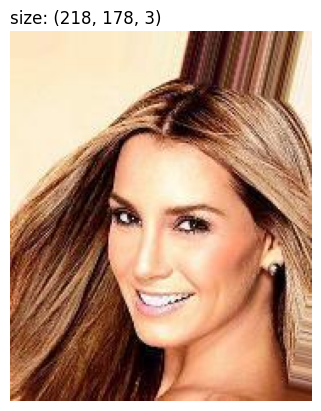

In [5]:
# Taking a sample images
image_sample_path = '/kaggle/input/gender-dataset/Dataset/Train/Female/000001.jpg'

read_plot_image(image_sample_path)

In [6]:
start_time = time.time()
parent_dir = ['/kaggle/input/gender-dataset/Dataset/Validation/Male', '/kaggle/input/gender-dataset/Dataset/Validation/Female',
              '/kaggle/input/gender-dataset/Dataset/Test/Male', '/kaggle/input/gender-dataset/Dataset/Test/Female']

tfrecord_filename = ['/kaggle/working/valid_male', '/kaggle/working/valid_female',
                     '/kaggle/working/test_male', '/kaggle/working/test_female']

for i in range(4):
    label = 1 if i%2==0 else 0
    tfrecord_utils.write_as_tfrecord(
        parent_dir=parent_dir[i],
        tfrecord_filename=tfrecord_filename[i],
        label=label,
        n_shards=10,
        max_workers=3000,
    )

#     as a confirmation
    print(parent_dir[i], tfrecord_filename[i], label)
end_time = time.time()
print(f'Program took {(end_time-start_time)/60}mins to complete')



# file_pattern = '/kaggle/working/train_male.tfrecord-*-of-*'
# match_files = glob.glob(file_pattern)

# for file in match_files:
# #     pass
#     os.remove(file)

Writing TFRecords: 100%|██████████| 8820/8820 [00:00<00:00, 59312.06it/s]


done writing
/kaggle/input/gender-dataset/Dataset/Validation/Male /kaggle/working/valid_male 1


Writing TFRecords: 100%|██████████| 13778/13778 [00:00<00:00, 57818.26it/s] 


done writing
/kaggle/input/gender-dataset/Dataset/Validation/Female /kaggle/working/valid_female 0


Writing TFRecords: 100%|██████████| 8459/8459 [00:00<00:00, 58692.60it/s]


done writing
/kaggle/input/gender-dataset/Dataset/Test/Male /kaggle/working/test_male 1


Writing TFRecords: 100%|██████████| 11542/11542 [00:00<00:00, 55854.30it/s] 


done writing
/kaggle/input/gender-dataset/Dataset/Test/Female /kaggle/working/test_female 0
Program took 0.8119277596473694mins to complete


In [7]:
train_male_pattern = '/kaggle/input/male-tfrecord-dataset/train_male.tfrecord-*-of-*'
train_female_pattern = '/kaggle/input/female-tfrecord-dataset/train_female.tfrecord-*-of-*'

valid_male_pattern = '/kaggle/working/valid_male.tfrecord-*-of-*'
valid_female_pattern = '/kaggle/working/valid_female.tfrecord-*-of-*'

test_female_pattern = '/kaggle/working/test_female.tfrecord-*-of-*'
test_male_pattern = '/kaggle/working/test_male.tfrecord-*-of-*'


train_male_filepaths = glob.glob(train_male_pattern)
train_female_filepaths = glob.glob(train_female_pattern)

valid_male_filepaths = glob.glob(valid_male_pattern)
valid_female_filepaths = glob.glob(valid_female_pattern)

test_male_filepaths = glob.glob(test_male_pattern)
test_female_filepaths = glob.glob(test_female_pattern)


def shuffle_file_paths(paths_1, paths_2):
    filepaths = []
    for i in range(len(train_male_filepaths)):
        assert(len(paths_1) == len(paths_2))
        filepaths.extend([paths_1[i], paths_2[i]])
    return filepaths


train_filepaths = shuffle_file_paths(train_male_filepaths, train_female_filepaths)
valiid_filepaths = valid_male_filepaths+valid_female_filepaths

train_file_dataset = tf.data.Dataset.from_tensor_slices(train_filepaths)
valid_file_dataset = tf.data.Dataset.from_tensor_slices(valiid_filepaths)
test_male_file_dataset = tf.data.Dataset.from_tensor_slices(test_male_filepaths)
test_female_file_dataset = tf.data.Dataset.from_tensor_slices(test_female_filepaths)


list(train_file_dataset)

[<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/male-tfrecord-dataset/train_male.tfrecord-18-of-20'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/female-tfrecord-dataset/train_female.tfrecord-16-of-20'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/male-tfrecord-dataset/train_male.tfrecord-19-of-20'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/female-tfrecord-dataset/train_female.tfrecord-19-of-20'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/male-tfrecord-dataset/train_male.tfrecord-03-of-20'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/female-tfrecord-dataset/train_female.tfrecord-20-of-20'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/male-tfrecord-dataset/train_male.tfrecord-13-of-20'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/female-tfrecord-dataset/train_female.tfrecord-13-of-20'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/male-tfrecord-dataset

In [8]:
train_set = preprocess.gender_dataset(
    filepaths=train_file_dataset,
    repeat=2,
    normalise=False,
    augment=None,
    shuffle_buffer_size=10_000,
    cache=None,
    batch_size=128,
    image_shape=(218, 178, 3),
    n_reads=tf.data.AUTOTUNE,
    prefetch=tf.data.AUTOTUNE,
)

valid_set = preprocess.gender_dataset(
    filepaths=valid_file_dataset,
    batch_size=128,
    image_shape=(218, 178, 3),
    n_reads=tf.data.AUTOTUNE,
    prefetch=tf.data.AUTOTUNE,
)

test_male_set = preprocess.gender_dataset(
    test_male_file_dataset,
    batch_size=128,
    n_reads=tf.data.AUTOTUNE
)

test_female_set = preprocess.gender_dataset(
    test_female_file_dataset,
    batch_size=128,
    n_reads=tf.data.AUTOTUNE
)

In [9]:
model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer              │ (None, 218, 178, 3)    │             0 │
│ (AugmentationLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cov2d_1 (Conv2D)                │ (None, 218, 178, 32)   │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 218, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swish_activation_1 (Activation) │ (None, 218, 178, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 109, 89, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cov2d_2 (Conv2D)                │ (None, 109, 89, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 109, 89, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swish_activation_2 (Activation) │ (None, 109, 89, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 54, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cov2d_3 (Conv2D)                │ (None, 54, 44, 96)     │        55,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 54, 44, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swish_activation_3 (Activation) │ (None, 54, 44, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 27, 22, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cov2d_4 (Conv2D)                │ (None, 27, 22, 128)    │       110,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 27, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swish_activation_4 (Activation) │ (None, 27, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_4 (MaxPooling2D)      │ (None, 13, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer_1 (Flatten)       │ (None, 18304)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 18304)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 512)            │     9,371,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swish_activation_5 (Activation) │ (None, 512)            │             

 Total params: 9,562,209 (36.48 MB)

 Trainable params: 9,560,545 (36.47 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Create callbacks
lr_performance_schedule_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0005,
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode='max',
    restore_best_weights=True,
)


model_weight_filepath = '/kaggle/working/model_best_weights.weights.h5'

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_weight_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch',
)

callbacks = {
    'ReduceLROnPlateau':lr_performance_schedule_cb, 
    'ModelCheckpoint':checkpoint_cb,
    'EarlyStopping': early_stopping_cb
}

In [11]:
model_filepath = '/kaggle/working/model_1.keras'

optimiser = tf.keras.optimizers.Nadam()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

hystroy = train.train_model(
    model,
    X_train=train_set,
    valid_set=valid_set,
    epochs=60,
    optimiser=optimiser,
    loss=loss_fn,
    callbacks=callbacks,
    retrieve_weights_from=model_weight_filepath,
    save_weights_to=model_weight_filepath,
    with_aug_layer=True,
    aug_layer_name=None,
    insert_dropout=None,
    save_model_to=model_filepath,
    initial_epoch=10
)

177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9770 - loss: 0.0684
Model loaded weights with best_val_accuracy: 0.9815912842750549
Training with with_aug_layer=True
Epoch 11/60


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


   2500/Unknown 637s 248ms/step - accuracy: 0.9750 - loss: 0.0682
Epoch 11: val_accuracy improved from -inf to 0.98084, saving model to /kaggle/working/model_best_weights.weights.h5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 648s 252ms/step - accuracy: 0.9750 - loss: 0.0682 - val_accuracy: 0.9808 - val_loss: 0.0548 - learning_rate: 0.0010
Epoch 12/60
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9759 - loss: 0.0645
Epoch 12: val_accuracy did not improve from 0.98084
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 628s 251ms/step - accuracy: 0.9759 - loss: 0.0645 - val_accuracy: 0.9798 - val_loss: 0.0551 - learning_rate: 0.0010
Epoch 13/60
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9784 - loss: 0.0588
Epoch 13: val_accuracy did not improve from 0.98084
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 641s 256ms/step - accuracy: 0.9784 - loss: 0.0588 - val_accuracy: 0.9784 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 14/60
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9789 - loss: 0.0575


KeyboardInterrupt: 